# Predict Goals from Parameters

Using the samples I generated, I want to see if I can predict clinical goals based on the dose parameters.
I'll try using Gaussian processes, so I first need to see what kernels work best.
I think it'd be cool to have an interactive dashboard where you can modify the parameters and see an updated estimate for the clinical goals.
It'd be even better to have a prediction of the dose-volume histograms, but that'd be a lot more expensive, since you'd have to predict hundreds of values rather than just one.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
sns.set(color_codes=True, font_scale=1.2)
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process import kernels
import utils

samples = np.load('samples_6_5.npy', allow_pickle=True)

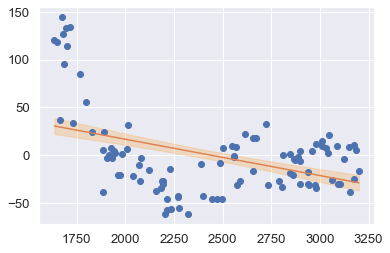

In [2]:
chest = np.array(utils.roi_pars(samples, 'Rib')[0]).reshape(-1, 1)
lung = np.array(utils.roi_stats(samples, 'PTV', 'Max'))

gpr = GaussianProcessRegressor(kernel=kernels.DotProduct(), alpha=np.var(lung)).fit(chest, lung-np.mean(lung))

x_vals = np.linspace(min(chest), max(chest), 100).reshape(-1, 1)
y_mean, y_std = gpr.predict(x_vals, return_std=True)

plt.plot(chest, lung-np.mean(lung), 'o')
plt.plot(x_vals, y_mean)
plt.fill_between(x_vals.squeeze(), y_mean - y_std, y_mean + y_std, color='darkorange', alpha=0.2)

Text(0, 0.5, 'Rib Goal 2')

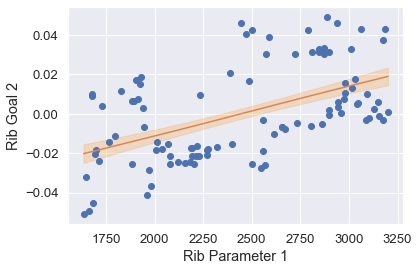

In [3]:
x = np.array(utils.roi_pars(samples, 'Rib')[0]).reshape(-1, 1)
y = np.array(utils.roi_goals(samples, 'SpinalCanal')[0])

gpr = GaussianProcessRegressor(kernel=kernels.Matern(), alpha=np.var(y)).fit(x, y - np.mean(y))

x_vals = np.linspace(min(chest), max(chest), 100).reshape(-1, 1)
y_mean, y_std = gpr.predict(x_vals, return_std=True)

plt.plot(x, y - np.mean(y), 'o')
plt.plot(x_vals, y_mean)
plt.fill_between(x_vals.squeeze(), y_mean - y_std, y_mean + y_std, color='darkorange', alpha=0.2)
plt.xlabel('Rib Parameter 1')
plt.ylabel('Rib Goal 2')

In [ ]:
# Was going to make a function to interpolate data (or predict with GP),
# Then see how the function varies with it...

# Guessing that the Rib parameter is really the most important here,
# is that still true with the function values?

# Could also plot function vs. parameter value (though it would be a projection since five parameters...)

Text(0, 0.5, 'Lungs Average')

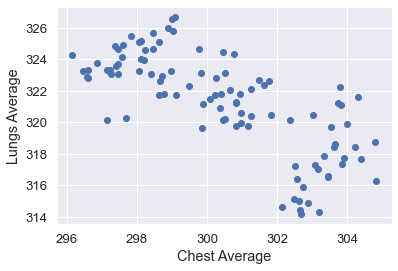

In [4]:
stat = 'Average'
plt.plot(utils.roi_stats(samples, 'Chestwall_L', stat), utils.roi_stats(samples, 'Lungs', stat), 'o')
plt.xlabel(f'Chest {stat}')
plt.ylabel(f'Lungs {stat}')